In [3]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.8.0+cu129
2.8.0+cpu


In [4]:
%pip install boto3

Note: you may need to restart the kernel to use updated packages.


In [5]:
import io
import os
import tarfile
import tempfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio
from torchaudio.utils import download_asset

SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_WAV_8000 = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")


def _hide_seek(obj):
    class _wrapper:
        def __init__(self, obj):
            self.obj = obj

        def read(self, n):
            return self.obj.read(n)

    return _wrapper(obj)

C:\Users\zpfh1\AppData\Local\Temp\ipykernel_39464\2415713283.py:14: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
C:\Users\zpfh1\AppData\Local\Temp\ipykernel_39464\2415713283.py:15: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
C:\Users\zpfh1\AppData\Local\Temp\ipykernel_39464\2415713283.py:16: UserWarning

In [6]:
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


C:\Users\zpfh1\AppData\Local\Temp\ipykernel_39464\3458049858.py:1: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  metadata = torchaudio.info(SAMPLE_WAV)
c:\Users\zpfh1\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchaudio\_backend\soundfile_backend.py:120: UserWarning: torchaudio._backend.common.AudioMetaData has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more inform

In [7]:
metadata = torchaudio.info(SAMPLE_GSM)
print(metadata)

AudioMetaData(sample_rate=8000, num_frames=39680, num_channels=1, bits_per_sample=0, encoding=UNKNOWN)


C:\Users\zpfh1\AppData\Local\Temp\ipykernel_39464\1056785358.py:1: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  metadata = torchaudio.info(SAMPLE_GSM)


In [8]:
import requests
import torchaudio
from io import BytesIO

url = "https://download.pytorch.org/torchaudio/tutorial-assets/steam-train-whistle-daniel_simon.wav"
response = requests.get(url)
audio_bytes = BytesIO(response.content)
metadata = torchaudio.info(audio_bytes)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


C:\Users\zpfh1\AppData\Local\Temp\ipykernel_39464\1302138694.py:8: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  metadata = torchaudio.info(audio_bytes)


In [9]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

c:\Users\zpfh1\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


In [12]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

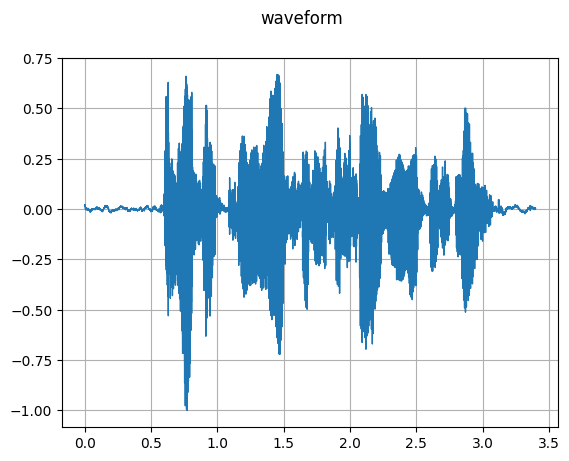

In [13]:
plot_waveform(waveform, sample_rate)

In [15]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

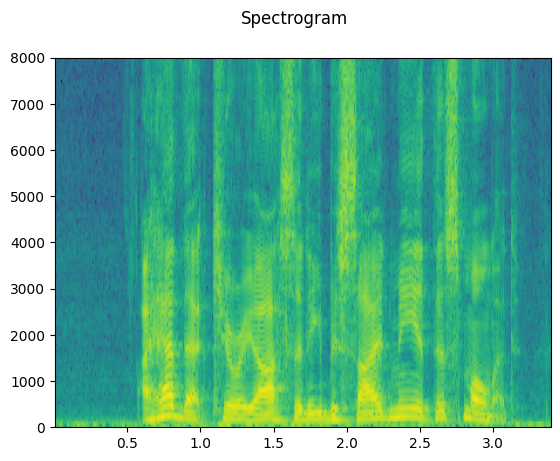

In [16]:
plot_specgram(waveform, sample_rate)

In [19]:
Audio(waveform.numpy()[0], rate=sample_rate)

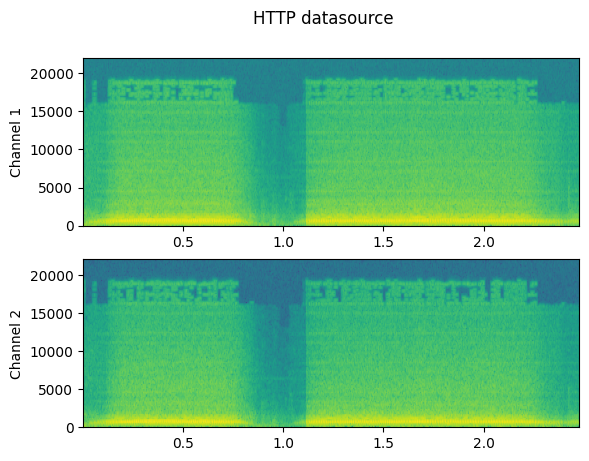

In [ ]:

response = requests.get(url)
audio_bytes = BytesIO(response.content)
waveform, sample_rate = torchaudio.load(audio_bytes)
plot_specgram(waveform, sample_rate, title="HTTP datasource")

C:\Users\zpfh1\AppData\Local\Temp\ipykernel_39464\2384981077.py:2: UserWarning: torchaudio.utils.download.download_asset has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  tar_path = download_asset("tutorial-assets/VOiCES_devkit.tar.gz")


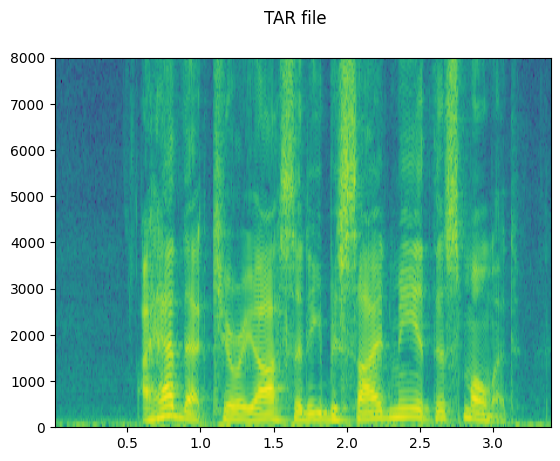

In [21]:
# Load audio from tar file
tar_path = download_asset("tutorial-assets/VOiCES_devkit.tar.gz")
tar_item = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
with tarfile.open(tar_path, mode="r") as tarfile_:
    fileobj = tarfile_.extractfile(tar_item)
    waveform, sample_rate = torchaudio.load(fileobj)
plot_specgram(waveform, sample_rate, title="TAR file")

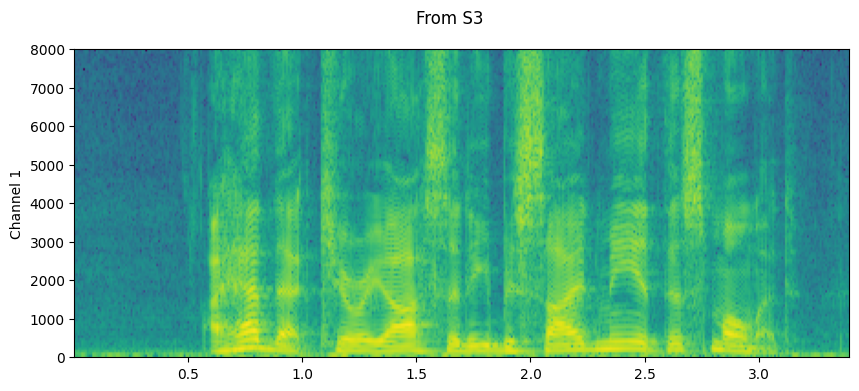

In [ ]:
import io
import boto3
import torchaudio
import matplotlib.pyplot as plt
from botocore import UNSIGNED
from botocore.config import Config

# S3 버킷과 키
bucket = "pytorch-tutorial-assets"
key = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

# S3에서 객체 가져오기 공개 버킷 unsigned
client = boto3.client("s3", config=Config(signature_version=UNSIGNED))
response = client.get_object(Bucket=bucket, Key=key)

# Body를 BytesIO로 감싸기
body_bytes = io.BytesIO(response["Body"].read())

# torchaudio로 로드
waveform, sample_rate = torchaudio.load(body_bytes)

# 스펙트로그램 출력 함수
def plot_specgram(waveform, sample_rate, title="From S3"):
    wf = waveform.numpy()
    num_channels = wf.shape[0]
    fig, axes = plt.subplots(num_channels, 1, figsize=(10, 4))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(wf[c], Fs=sample_rate)
        axes[c].set_ylabel(f"Channel {c+1}")
    fig.suptitle(title)
    plt.show()

# 실행
plot_specgram(waveform, sample_rate, title="From S3")


In [ ]:
import io
import requests
import torchaudio

frame_offset, num_frames = 16000, 16000  # 1-2초

url = "https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

print("Fetching all the data...")
with requests.get(url, stream=True) as response:
    # 전체 데이터를 BytesIO로 읽기
    file_obj = io.BytesIO(response.content)
    waveform1, sample_rate1 = torchaudio.load(file_obj)
    waveform1 = waveform1[:, frame_offset : frame_offset + num_frames]
    print(f" - Fetched {file_obj.tell()} bytes")

print("Fetching until the requested frames are available...")
with requests.get(url, stream=True) as response:
    # 부분만 읽dm면 마찬가지로 BytesIO 사용
    file_obj = io.BytesIO(response.content)
    waveform2, sample_rate2 = torchaudio.load(
        file_obj, frame_offset=frame_offset, num_frames=num_frames
    )
    print(f" - Fetched {file_obj.tell()} bytes")

print("Checking the resulting waveform ... ", end="")
assert (waveform1 == waveform2).all()
print("matched!")


Fetching all the data...
 - Fetched 108844 bytes
Fetching until the requested frames are available...
 - Fetched 64044 bytes
Checking the resulting waveform ... matched!


In [27]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

In [28]:
def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")
    print()

In [29]:
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_default.wav"
    torchaudio.save(path, waveform, sample_rate)
    inspect_file(path)

----------
Source: C:\Users\zpfh1\AppData\Local\Temp\tmp488anouc/save_example_default.wav
----------
 - File size: 217680 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=32, encoding=PCM_F)



c:\Users\zpfh1\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchaudio\_backend\utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
C:\Users\zpfh1\AppData\Local\Temp\ipykernel_39464\3348391189.py:6: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  pr

In [30]:
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_PCM_S16.wav"
    torchaudio.save(path, waveform, sample_rate, encoding="PCM_S", bits_per_sample=16)
    inspect_file(path)

----------
Source: C:\Users\zpfh1\AppData\Local\Temp\tmphkiiqkjf/save_example_PCM_S16.wav
----------
 - File size: 108844 bytes
 - AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)



C:\Users\zpfh1\AppData\Local\Temp\ipykernel_39464\3348391189.py:6: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  print(f" - {torchaudio.info(path)}")


In [31]:
formats = [
    "flac",
    # "vorbis",
    # "sph",
    # "amb",
    # "amr-nb",
    # "gsm",
]

In [32]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_8000)
with tempfile.TemporaryDirectory() as tempdir:
    for format in formats:
        path = f"{tempdir}/save_example.{format}"
        torchaudio.save(path, waveform, sample_rate, format=format)
        inspect_file(path)

----------
Source: C:\Users\zpfh1\AppData\Local\Temp\tmpwd9fze8a/save_example.flac
----------
 - File size: 37100 bytes
 - AudioMetaData(sample_rate=8000, num_frames=27200, num_channels=1, bits_per_sample=16, encoding=FLAC)



C:\Users\zpfh1\AppData\Local\Temp\ipykernel_39464\3348391189.py:6: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  print(f" - {torchaudio.info(path)}")


In [33]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

# Saving to bytes buffer
buffer_ = io.BytesIO()
torchaudio.save(buffer_, waveform, sample_rate, format="wav")

buffer_.seek(0)
print(buffer_.read(16))

b'RIFFHR\x03\x00WAVEfmt '


In [35]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

2.8.0+cu129
2.8.0+cpu


In [38]:
%pip install resampy

  Using cached resampy-0.4.3-py3-none-any.whl.metadata (3.0 kB)
Using cached resampy-0.4.3-py3-none-any.whl (3.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [42]:
import math
import timeit

import librosa
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import resampy
from IPython.display import Audio

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

DEFAULT_OFFSET = 201


def _get_log_freq(sample_rate, max_sweep_rate, offset):
    """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

    offset is used to avoid negative infinity `log(offset + x)`.

    """
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset


def _get_inverse_log_freq(freq, sample_rate, offset):
    """Find the time where the given frequency is given by _get_log_freq"""
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))


def _get_freq_ticks(sample_rate, offset, f_max):
    # Given the original sample rate used for generating the sweep,
    # find the x-axis value where the log-scale major frequency values fall in
    times, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10**exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                times.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    times.append(t_max)
    freq.append(f_max)
    return times, freq


def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal


def plot_sweep(
    waveform,
    sample_rate,
    title,
    max_sweep_rate=48000,
    offset=DEFAULT_OFFSET,
):
    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f in y_ticks and 1000 <= f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1)
    _, _, _, cax = axis.specgram(waveform[0].numpy(), Fs=sample_rate)
    plt.xticks(time, freq_x)
    plt.yticks(freq_y, freq_y)
    axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
    axis.set_ylabel("Waveform Frequency (Hz)")
    axis.xaxis.grid(True, alpha=0.67)
    axis.yaxis.grid(True, alpha=0.67)
    figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
    plt.colorbar(cax)

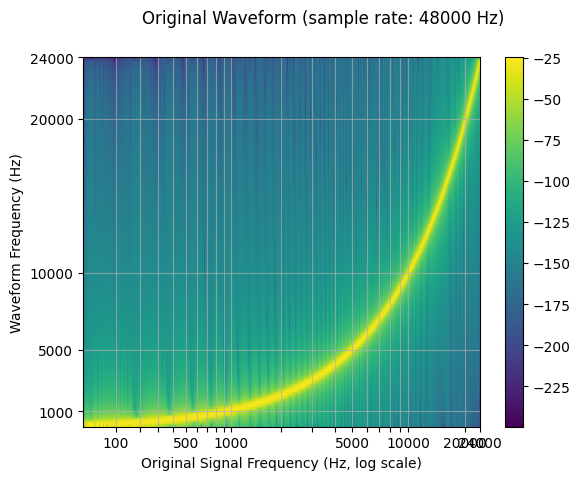

In [43]:
sample_rate = 48000
waveform = get_sine_sweep(sample_rate)

plot_sweep(waveform, sample_rate, title="Original Waveform")
Audio(waveform.numpy()[0], rate=sample_rate)

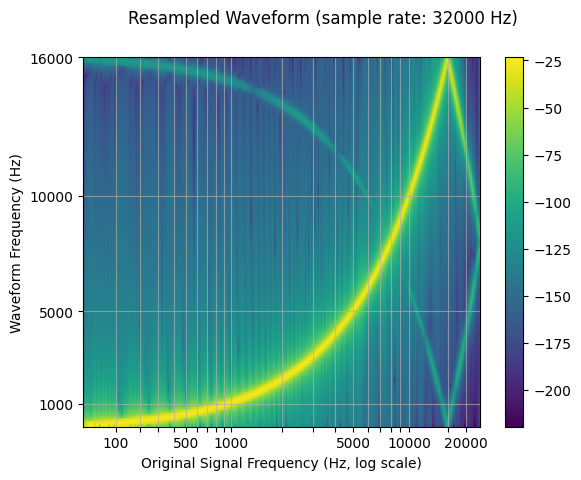

In [44]:
resample_rate = 32000
resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)

plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")
Audio(resampled_waveform.numpy()[0], rate=resample_rate)

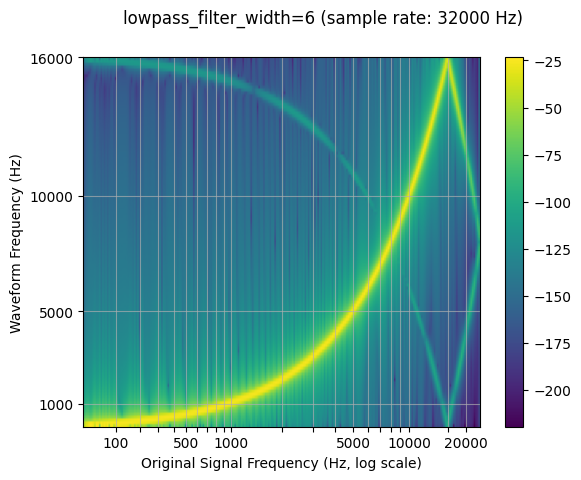

In [45]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=6")

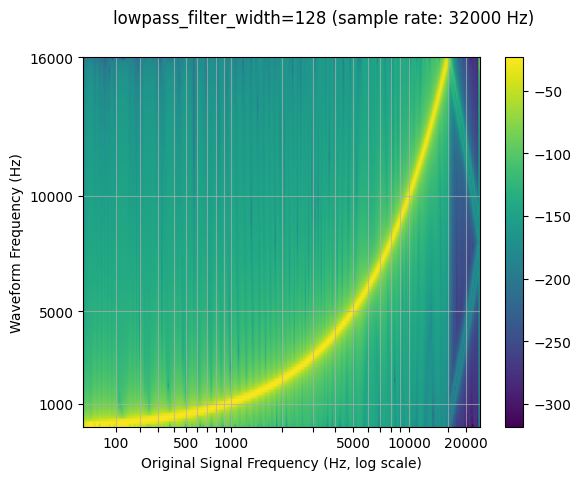

In [46]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=128)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=128")

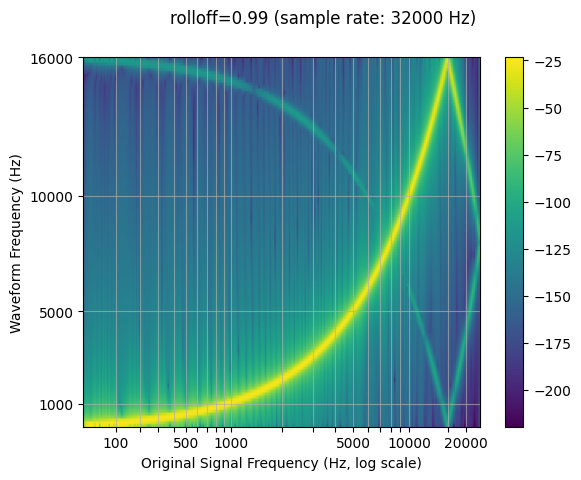

In [47]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.99)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.99")

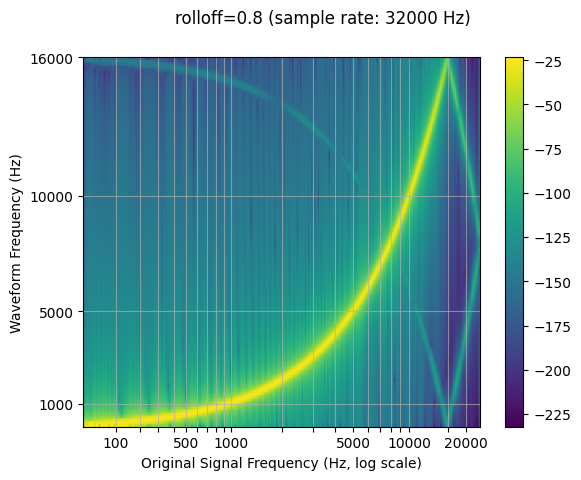

In [48]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.8)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.8")

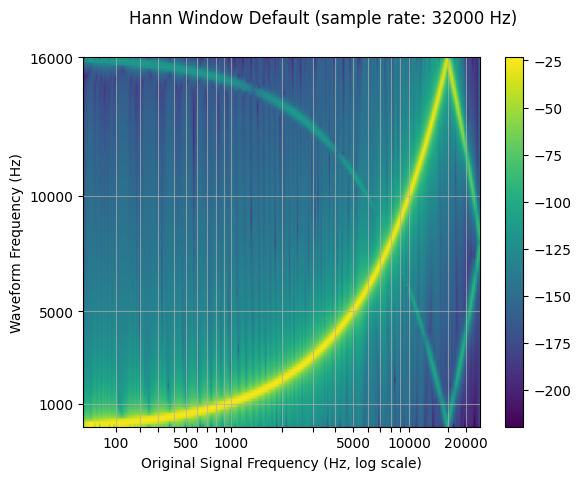

In [49]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interp_hann")
plot_sweep(resampled_waveform, resample_rate, title="Hann Window Default")

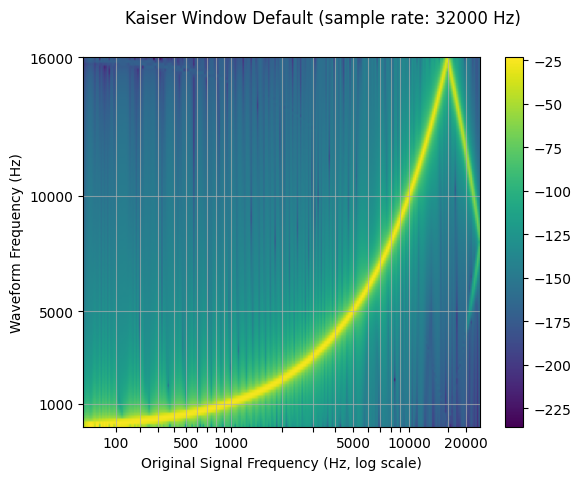

In [50]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interp_kaiser")
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Default")

In [51]:
sample_rate = 48000
resample_rate = 32000

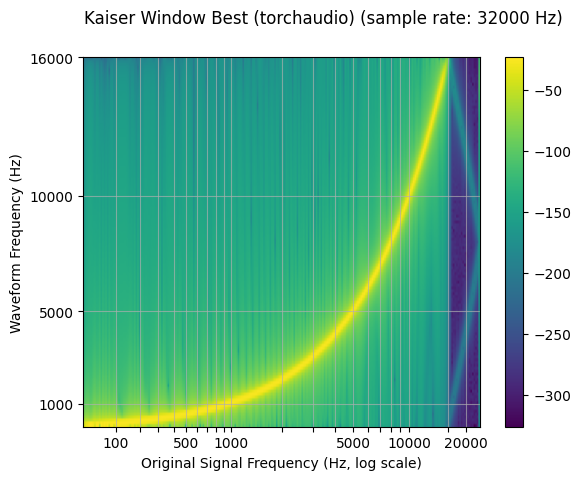

In [52]:
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=64,
    rolloff=0.9475937167399596,
    resampling_method="sinc_interp_kaiser",
    beta=14.769656459379492,
)
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Best (torchaudio)")

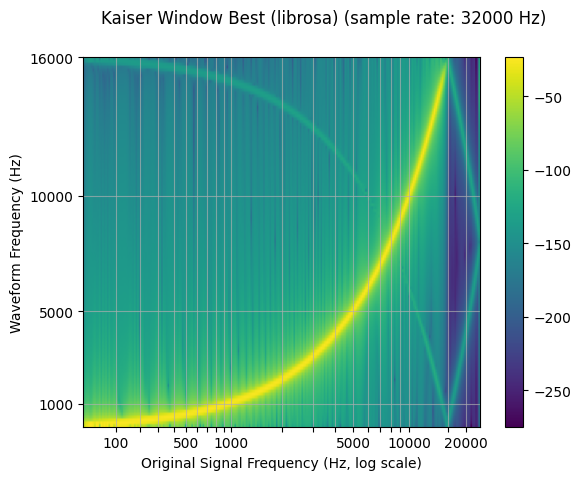

In [53]:
librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), orig_sr=sample_rate, target_sr=resample_rate, res_type="kaiser_best")
).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Best (librosa)")

In [54]:
mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser best MSE:", mse)

torchaudio and librosa kaiser best MSE: 0.0013004566355607605


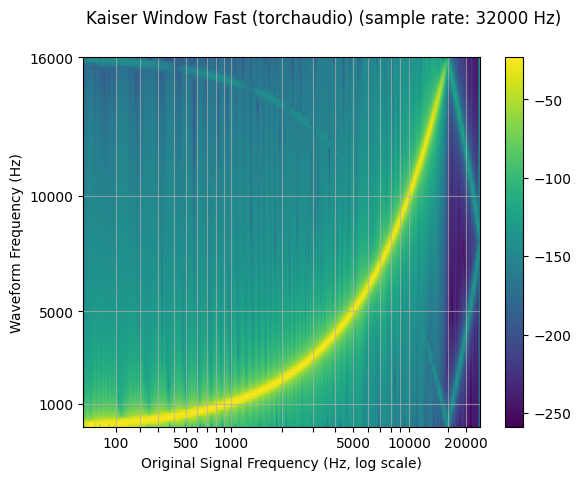

In [55]:
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=16,
    rolloff=0.85,
    resampling_method="sinc_interp_kaiser",
    beta=8.555504641634386,
)
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Fast (torchaudio)")

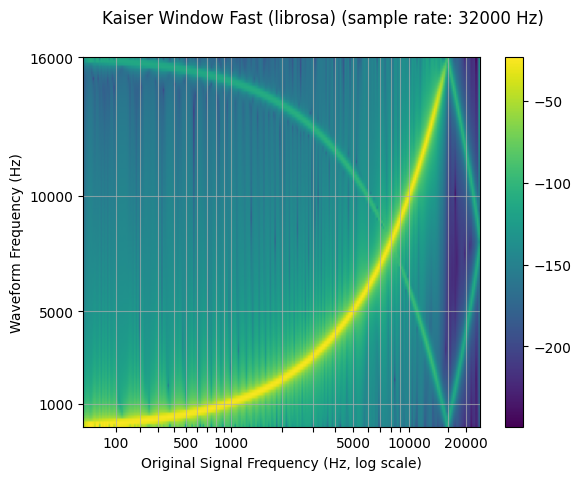

In [56]:
librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), orig_sr=sample_rate, target_sr=resample_rate, res_type="kaiser_fast")
).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Fast (librosa)")

In [57]:
mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser fast MSE:", mse)

torchaudio and librosa kaiser fast MSE: 0.0002567981251853152


In [58]:
print(f"torchaudio: {torchaudio.__version__}")
print(f"librosa: {librosa.__version__}")
print(f"resampy: {resampy.__version__}")

torchaudio: 2.8.0+cpu
librosa: 0.11.0
resampy: 0.4.3


In [59]:
def benchmark_resample_functional(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=6,
    rolloff=0.99,
    resampling_method="sinc_interp_hann",
    beta=None,
    iters=5,
):
    return (
        timeit.timeit(
            stmt="""
torchaudio.functional.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=lowpass_filter_width,
    rolloff=rolloff,
    resampling_method=resampling_method,
    beta=beta,
)
        """,
            setup="import torchaudio",
            number=iters,
            globals=locals(),
        )
        * 1000
        / iters
    )

In [60]:
def benchmark_resample_transforms(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=6,
    rolloff=0.99,
    resampling_method="sinc_interp_hann",
    beta=None,
    iters=5,
):
    return (
        timeit.timeit(
            stmt="resampler(waveform)",
            setup="""
import torchaudio

resampler = torchaudio.transforms.Resample(
    sample_rate,
    resample_rate,
    lowpass_filter_width=lowpass_filter_width,
    rolloff=rolloff,
    resampling_method=resampling_method,
    dtype=waveform.dtype,
    beta=beta,
)
resampler.to(waveform.device)
        """,
            number=iters,
            globals=locals(),
        )
        * 1000
        / iters
    )

In [62]:
def benchmark_resample_librosa(
    waveform,
    sample_rate,
    resample_rate,
    res_type=None,
    iters=5,
):
    waveform_np = waveform.squeeze().numpy()
    return (
        timeit.timeit(
            stmt="""
librosa.resample(
    waveform_np,
    orig_sr=sample_rate,
    target_sr=resample_rate,
    res_type=res_type,
)
        """,
            setup="import librosa",
            number=iters,
            globals=locals(),
        )
        * 1000
        / iters
    )

In [63]:
def benchmark(sample_rate, resample_rate):
    times, rows = [], []
    waveform = get_sine_sweep(sample_rate).to(torch.float32)

    args = (waveform, sample_rate, resample_rate)

    # sinc 64 zero-crossings
    f_time = benchmark_resample_functional(*args, lowpass_filter_width=64)
    t_time = benchmark_resample_transforms(*args, lowpass_filter_width=64)
    times.append([None, f_time, t_time])
    rows.append("sinc (width 64)")

    # sinc 6 zero-crossings
    f_time = benchmark_resample_functional(*args, lowpass_filter_width=16)
    t_time = benchmark_resample_transforms(*args, lowpass_filter_width=16)
    times.append([None, f_time, t_time])
    rows.append("sinc (width 16)")

    # kaiser best
    kwargs = {
        "lowpass_filter_width": 64,
        "rolloff": 0.9475937167399596,
        "resampling_method": "sinc_interp_kaiser",
        "beta": 14.769656459379492,
    }
    lib_time = benchmark_resample_librosa(*args, res_type="kaiser_best")
    f_time = benchmark_resample_functional(*args, **kwargs)
    t_time = benchmark_resample_transforms(*args, **kwargs)
    times.append([lib_time, f_time, t_time])
    rows.append("kaiser_best")

    # kaiser fast
    kwargs = {
        "lowpass_filter_width": 16,
        "rolloff": 0.85,
        "resampling_method": "sinc_interp_kaiser",
        "beta": 8.555504641634386,
    }
    lib_time = benchmark_resample_librosa(*args, res_type="kaiser_fast")
    f_time = benchmark_resample_functional(*args, **kwargs)
    t_time = benchmark_resample_transforms(*args, **kwargs)
    times.append([lib_time, f_time, t_time])
    rows.append("kaiser_fast")

    df = pd.DataFrame(times, columns=["librosa", "functional", "transforms"], index=rows)
    return df
def plot(df):
    print(df.round(2))
    ax = df.plot(kind="bar")
    plt.ylabel("Time Elapsed [ms]")
    plt.xticks(rotation=0, fontsize=10)
    for cont, col, color in zip(ax.containers, df.columns, mcolors.TABLEAU_COLORS):
        label = ["N/A" if v != v else str(v) for v in df[col].round(2)]
        ax.bar_label(cont, labels=label, color=color, fontweight="bold", fontsize="x-small")

                 librosa  functional  transforms
sinc (width 64)      NaN        5.86        1.59
sinc (width 16)      NaN        2.51        1.45
kaiser_best        27.84        6.38        1.60
kaiser_fast         7.79        3.69        1.47


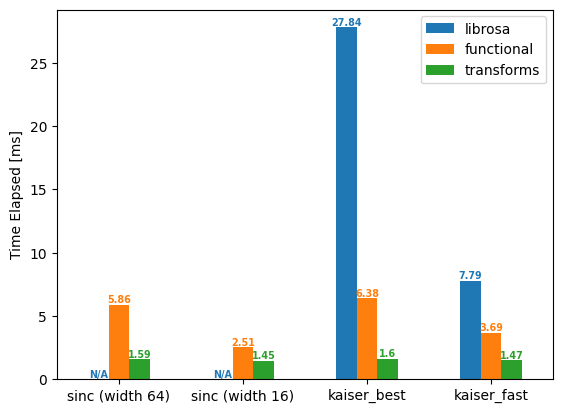

In [64]:
df = benchmark(48_000, 44_100)
plot(df)

                 librosa  functional  transforms
sinc (width 64)      NaN        1.55        1.21
sinc (width 16)      NaN        1.37        0.84
kaiser_best        20.33        2.30        1.71
kaiser_fast         3.58        1.68        1.09


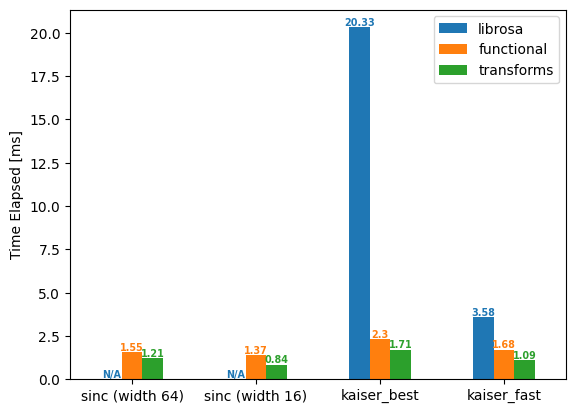

In [65]:
df = benchmark(16_000, 8_000)
plot(df)

                 librosa  functional  transforms
sinc (width 64)      NaN        2.73        1.67
sinc (width 16)      NaN        1.99        1.10
kaiser_best        18.13        2.13        1.58
kaiser_fast         2.91        2.19        1.56


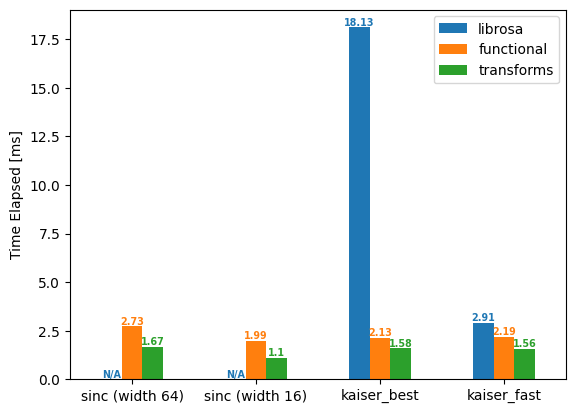

In [66]:
df = benchmark(8_000, 16_000)
plot(df)